# Homework 4: Coding is $\sqrt{\text{evil}}$

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import standard_normal
from scipy.linalg import qr, svd

def _load_data(path):
    return np.loadtxt(path)

def _save_results(U, s):
    np.savetxt("svectors.txt", U, fmt="%.6f")
    np.savetxt("svalues.txt",  s, fmt="%.6f")

### 1. Particle Swarm Optimization
Particle Swarm Optimization (PSO) is yet another nature-inspired search algorithm that attempts to strike a balance between exploration (conducting fast but low-resolution searches of large parameter spaces) with exploitation (refining promising but small areas of the total search space).

[Here is a Matlab plot of PSO in action](https://www.youtube.com/watch?v=lX5qJimYusQ): notice how the majority of agents (dots) very quickly gather in the bottom left corner (exploitation) representing the global minimum, but there are nonetheless a few dots that appear elsewhere on the energy landscape (exploration).

Rather than devote a third homework assignment’s coding section to yet another document classification scheme, we’ll explore PSO from a more theoretical viewpoint. PSO was introduced in 1995, and was inspired by the movement of groups of animals: insects, birds, and fish in particular. Virtual particles “swarm” the search space using a directed but stochastic algorithm designed to modulate efforts to find the global extremum (exploitation) while avoiding getting stuck in local extrema (exploration). It is relatively straightforward to implement and easy to parallelize; however, it is slow to converge to global optima, and ultimately cannot guarantee convergence to global optima.

Formally: $N$ particles move around the search space $\mathcal{R}^{n}$ according to a few very simple rules, which are predicated on:
- each particle’s individual best position so far, and
- the overall swarm’s best position so far

Each particle $i$ has a position $\vec{x}_{i}$, a velocity $\vec{v}_{i}$, and an optimal position so far $\vec{p}_{i}$, where $\vec{x}_{i}, \vec{v}_{i}, \vec{p}_{i} \in \mathcal{R}^{n}$.

Globally, there is an optimal swarm-level position $\vec{g} \in \mathcal{R}^{n}$ (the supremum of all $\vec{p}_{i}$), cognitive and social parameters $c_{1}$ and $c_{2}$, and an intertia factor $\omega$.

The update rule for velocity $\vec{v}_{i}$ at time $t + 1$ is as follows: $$\vec{v}_{i}(t+1) = \omega \vec{v}_{i}(t) + c_{1}r_{1}[\vec{p}_{i}(t) - \vec{x}_{i}(t)] + c_{2}r_{2}[\vec{g}(t) - \vec{x}_{i}(t)]$$ where $r_{1}, r_{2} \sim U(0, 1)^{n}$.

##### a. Explain the effects of the cognitive ($c_{1}$) and social ($c_{2}$) parameters on the particle’s velocity. What happens when one or both is small (i.e. close to 0)? What happens when one or both is large? Relate the effects of these parameters to their "nature"-based inspiration, if you can.

---

-  Cognitive term: “I’ve been here before and it was good, so let me head back toward my best-known spot.”
    - When close to 0, particles will ignore their past success, if too large, they may get stuck in local minima 
-  Social term: “Others found a better spot—let me head toward the swarm’s best-known location.”
    - When close to 0, particles will ignore other particle's success, and if too large all particles might zero in on a local minima

---

##### b. The inertia parameter $\omega$ in this formulation is typically started at $1$ and decreased slowly on each iteration of the optimization procedure. Why?

---

- It is shifting from exploration to exploitation. With high momentum, the particle prioritizes exploring a large area, where as with low momentum, it begins to prioritize depth and zero in on a minimum

---

##### c. What effects do the random numbers $r_{1}$ and $r_{2}$ have?

---

- it adds randomness to a particle's movements, so that each particle moves a little differently from the rest. prevents early convergence

---

##### d. One of the greatest advantages of PSO is that it is highly parallelizable. Throughout the iterative process of moving the particles, evaluating them against the objective function, and updating the identified optima, there is only a single step in the entire algorithm that requires synchronization between parallel processes. What step is that? Be specific!

---

- updating $\vec{g}$ is the only step that requires syncronization.

---

##### e. Give a concrete example of how the PSO formulation described here could be improved (better global estimate in the same amount of time, faster convergence, tighter global convergence bounds, etc); you don’t have to provide a specific implementation, but it should be clear how it would work (“more power”, therefore, is not a concrete example). Such formulations are easy to find online; I implore you to resist the urge to search! Please keep it brief; at maximum after 2-3 lines.

---

- instead of each particle moving in parallel, have "mini swarms" that move in parallel before merging. this could increase search area during exploration

---

### 2. Kernel Smoothing
In this problem, we’ll look at nonparametric kernel smoothing for approximating a function from noisy data. We’ll also throw in leave-one-out cross-validation to observe its effects on the learned function. For the sake of simplicity, we’ll stick with one-dimensional data.

We have a "dataset" $(x_{1}, y_{1}), (x_{2}, y_{2}), \ldots, (x_{n}, y_{n})$, as follows: $$y_{i} = f(x_{i}) + \epsilon_{i}$$ where $\epsilon_{i} \sim \mathcal{N}(0, \sigma^{2})$.

The goal of any regression problem is to estimate the true $f(x)$ with an empirical estimate $\hat{f}(x)$. The Nadaraya-Watson estimator is given by: $$\hat{f}(x_{k}) = \frac{\sum_{i=1}^{n}y_{i}K(\frac{|x_{i} - x_{k}|}{h})}{\sum_{i=1}^{n}K(\frac{|x_{i} - x_{k}|}{h})}$$ where $K(\cdot)$ is the kernel, $h$ is the bandwidth. In this example, we will use the Gaussian Kernel: $$K(a) = \frac{1}{\sqrt{2\pi}}\exp{\{\frac{-a^{2}}{2}\}}$$
In this equation, $h$ takes the place of the standard deviation, and the data point $x$ will take the place of the mean.

##### a. Write a basic Python program that generates our dataset:
- Sample $x_{i} \sim U(-5, 5)$ (that's a uniform distribution from $-5$ to $5$)
- Sample $\epsilon_{i} \sim \mathcal{N}(0, 0.1)$
- Set $y_{i} = \sin(x_{i}) + \epsilon_{i}$

In [6]:
def make_sin_data(n=100, rng_seed=0):
    """
    Generate the 1-D regression dataset
        x_i ~ Uniform(-5, 5)
        ε_i ~ N(0, 0.1)
        y_i = sin(x_i) + ε_i
    Returns
    -------
    x : (n,) ndarray  – predictors
    y : (n,) ndarray  – noisy responses
    """
    rng = np.random.default_rng(rng_seed)
    x = rng.uniform(-5.0, 5.0, size=n)
    noise = rng.normal(loc=0.0, scale=np.sqrt(0.1), size=n)
    y = np.sin(x) + noise
    return x, y

##### b. Implement a squared loss function $\ell(\cdot)$ (you can use vectorized NumPy arrays for this): $$\ell(y, \hat{f}(x)) = (y - \hat{f}(x))^{2}$$

In [7]:
def squared_loss(y_true, y_pred):
    """
    Squared-error loss ℓ(y, ŷ) = (y − ŷ)²  :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}

    Parameters
    ----------
    y_true : array-like, shape (n,)
        Ground-truth responses y_i.
    y_pred : array-like, shape (n,)
        Predicted values ŷ_i = \hat f(x_i).

    Returns
    -------
    ndarray
        Element-wise squared errors; use err.mean() for average loss.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return (y_true - y_pred) ** 2

##### c. Sample a dataset of size $n = 100$ and plot it; you can use `matplotlib.pyplot.scatter`. Overlay the scatter plot with the true regression function (meaning compute the $\sin(\cdot)$ of each $x_{i}$ and plot that in addition to the $y_{i}$ you computed); you can use `matplotlib.pyplot.plot`.

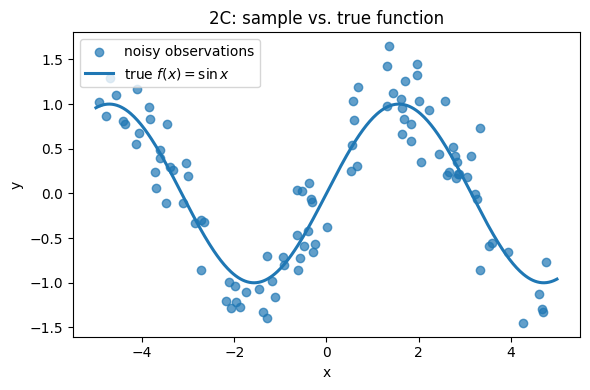

In [11]:
# --- 1. draw the training sample ---------------------------------
x_train, y_train = make_sin_data(n=100, rng_seed=42)

# --- 2. prepare the “ground-truth” curve --------------------------
#   (sorting not strictly required for scatter, but helps the line plot)
xs_fine = np.linspace(-5, 5, 400)
f_true  = np.sin(xs_fine)

# --- 3. visualise -------------------------------------------------
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train,
            alpha=0.7, label='noisy observations')
plt.plot(xs_fine, f_true,
         linewidth=2.2, label=r'true $f(x)=\sin x$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2C: sample vs. true function')
plt.legend()
plt.tight_layout()
plt.show()

##### d. Now, write a program which performs the following:
- Sample a “training set” of size $n = 100$, and a “testing set” of size $m = 100$.
- Compute the kernel smoother for a particular choice of $h$, along with the empirical error (average loss between all $y$ and $\hat{f}(x)$), leave-one-out cross-validation error (average loss), and testing error (average loss).
- Compute those measurements for the following values of $h \in \{1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001\}$.
- Construct scatter plots of test error versus empirical error, and test error versus leave-one-out cross-validation error. Test error should always be on the $y$-axis.
- Choose the function $\hat{f}$ which minimizes leave-one-out cross-validation error, and plot the training data sample along with the value of this function evaluated on the training data $x$ values.

/tmp/ipykernel_1301/2238381741.py:13: RuntimeWarning: invalid value encountered in divide
  weights = K / K.sum(axis=0)                       # normalise per column


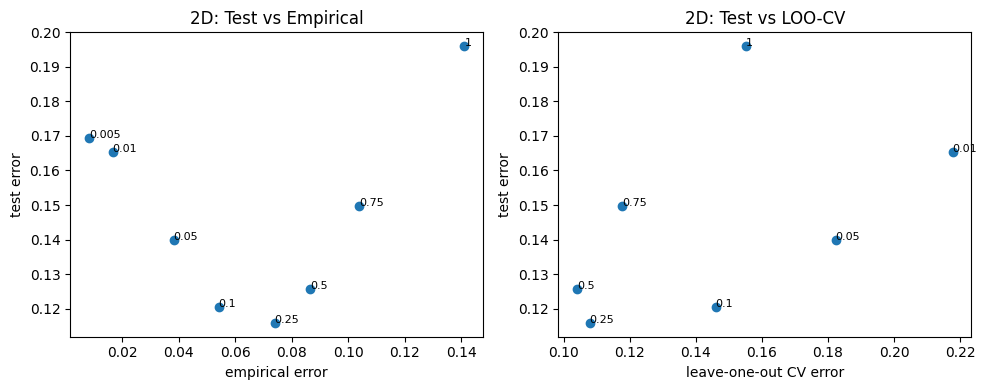

Best bandwidth by LOO-CV: h* = 0.005


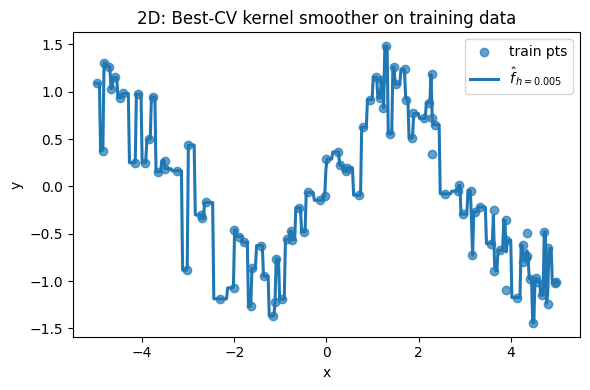

In [12]:
# 1.  Nadaraya–Watson kernel regressor  (Gaussian kernel)
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2)

def kernel_smoother(x_train, y_train, x_query, h):
    """
    Evaluate \hat f_h(x) for each x in `x_query` using the
    Nadaraya–Watson kernel estimator with Gaussian kernel.
    """
    # shape (n_train, n_query)
    u = (x_query[None, :] - x_train[:, None]) / h
    K = gaussian_kernel(u)
    weights = K / K.sum(axis=0)                       # normalise per column
    return (weights.T @ y_train)                      # (n_query,)

# 2.  set-up: sample train & test sets
x_train, y_train = make_sin_data(n=100, rng_seed=0)
x_test,  y_test  = make_sin_data(n=100, rng_seed=1)

# 3.  bandwidth sweep
hs = [1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]
results = []   # will hold tuples (h, emp_err, loo_err, test_err)

for h in hs:
    # 3a. empirical error on training set
    y_hat_train = kernel_smoother(x_train, y_train, x_train, h)
    emp_err = squared_loss(y_train, y_hat_train).mean()

    # 3b. leave-one-out CV: for each i, smooth w/out that point
    y_hat_loo = np.empty_like(y_train)
    for i in range(len(x_train)):
        mask       = np.ones_like(x_train, dtype=bool)
        mask[i]    = False
        y_hat_loo[i] = kernel_smoother(x_train[mask],
                                       y_train[mask],
                                       np.array([x_train[i]]),
                                       h)[0]
    loo_err = squared_loss(y_train, y_hat_loo).mean()

    # 3c. test error
    y_hat_test = kernel_smoother(x_train, y_train, x_test, h)
    test_err   = squared_loss(y_test, y_hat_test).mean()

    results.append((h, emp_err, loo_err, test_err))

# 4.  convert to NumPy for easy slicing
results = np.array(results, dtype=float)   # shape (9, 4)
# columns: 0-h, 1-emp, 2-loo, 3-test

# 5.  scatter plots  (test error always on y-axis)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(results[:, 1], results[:, 3])
for h, x, y in zip(results[:, 0], results[:, 1], results[:, 3]):
    plt.text(x, y, f"{h:g}", fontsize=8)
plt.xlabel("empirical error")
plt.ylabel("test error")
plt.title("2D: Test vs Empirical")

plt.subplot(1, 2, 2)
plt.scatter(results[:, 2], results[:, 3])
for h, x, y in zip(results[:, 0], results[:, 2], results[:, 3]):
    plt.text(x, y, f"{h:g}", fontsize=8)
plt.xlabel("leave-one-out CV error")
plt.ylabel("test error")
plt.title("2D: Test vs LOO-CV")

plt.tight_layout()
plt.show()

# 6.  pick h* that minimises LOO-CV   (tie-break = smaller h)
best_idx = results[:, 2].argmin()
h_star   = results[best_idx, 0]

print(f"Best bandwidth by LOO-CV: h* = {h_star:g}")

# 7.  plot training sample with fitted \hat f_{h*}
xs_fine = np.linspace(-5, 5, 400)
f_hat   = kernel_smoother(x_train, y_train, xs_fine, h_star)

plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=0.7, label='train pts')
plt.plot(xs_fine, f_hat, lw=2.2, label=fr'$\hat f_{{h={h_star:g}}}$')
plt.xlabel('x'); plt.ylabel('y')
plt.title('2D: Best-CV kernel smoother on training data')
plt.legend()
plt.tight_layout()
plt.show()

##### e. Explain why it is a bad idea to merely minimize the empirical risk in problems like this.
*Hint*: refer to the last two plots.

---

- Empirical risk rewards models for fitting noise and gives a systematically low estimate of generalisation error. In non-parametric settings where model complexity is controlled by a smoothing parameter like $h$, you need an unbiased proxy—such as leave-one-out CV—to balance bias and variance and avoid the over-fitting trap

---

### 3. Stochastic SVD
In this question, you’ll implement Stochastic SVD (SSVD) and compare its performance in certain applications. You are free to use the `scikit-learn` and `scipy.linalg` libraries.

The strength of SSVD lies in its reliance on randomization to generate an initial basis. In doing so, the rest of the algorithm becomes highly parallelizable; a [2011 PhD thesis](https://scholar.colorado.edu/concern/graduate_thesis_or_dissertations/gx41mh844) proposed this method for computing the SVD of extremely large datasets in a single pass.

Fundamentally, SSVD has two main phases. In the first phase, you are computing a *pre-conditioner matrix* $Q$ that, when applied to the data matrix $A$, “conditions” the system such that it is quantitatively better-behaved. Formally, it reduces the *condition number* $\kappa$ of the linear system, where $$\kappa = \frac{|\lambda_{\max}|}{|\lambda_{\min}|}$$ ($\lambda_{\max}$ is the largest eigenvalue of $A$, while $\lambda_{\min}$ is the smallest). In general, this quantity is a strong proxy for “stability” of the corresponding system: if the condition number of a system is small, then it tends to be a smooth, continuous system: small changes in input result in small changes in output. Accordingly, reducing this quantity has all kinds of benefits, chief in particular that makes the system easier to solve (in terms of finding the eigenvalues and eigenvectors, which as we know, SVD is related to that task).

In the second phase, we use our preconditioner $Q$ to compute a small matrix whose singular vectors *approximate* the basis of $A$, our data matrix. Then, by projecting the vectors back into the space of $A$ using our preconditioner $Q$, we arrive at an estimate of the true singular vectors of $A$, and therefore, an estimate of the eigen-decomposition of $A$.

In [20]:
path = "./X.txt"
print("Data file")
print(f"\n--- {path} ---")
with open(path) as f:
    for _ in range(5):
        line = f.readline()
        if not line:
            break
        print(line.rstrip())

Data file

--- ./X.txt ---
-0.004311 0.001529 0.001122 0.000884 0.004374 -0.000124 -0.000042 -0.001793 0.003084 -0.002559 -0.005743 -0.003101 0.000153 -0.000294 -0.000407 -0.005753 0.005849 -0.002910 -0.005465 0.005195 0.005365 -0.004023 0.011409 -0.003218 -0.001778 0.004635 -0.000053 0.003618 0.005333 -0.000824 -0.008722 0.000472 0.001700 -0.004238 0.001290 0.002196 0.001377 -0.001500 -0.004657 -0.002352 0.004427 0.000758 0.008873 -0.001857 0.006179 -0.005733 -0.003586 -0.004497 -0.002855 0.001523 0.001859 0.004165 0.001406 -0.005831 0.003237 -0.004700 -0.001870 -0.002605 0.009089 -0.000080 -0.007979 0.005747 -0.002771 0.003662 0.001558 -0.008887 -0.004993 -0.006038 0.000055 -0.001309 -0.002329 0.002914 0.003879 -0.004143 -0.008697 -0.000289 0.000707 0.002865 0.002958 -0.001591 -0.007153 -0.002823 0.000901 -0.002074 -0.007237 -0.003328 -0.002652 0.000865 0.003806 -0.001176 0.000133 -0.002720 0.003118 0.001280 0.004176 0.002812 -0.001758 -0.003298 0.001291 -0.000090
-0.001743 0.000068 

##### a. Start by implementing a Python function that computes the preconditioner matrix $Q$ from the data matrix $A \in \mathbb{R}^{n \times m}$ for some number of basis vectors $k$, where $1 \le k \le m$:
1. Create a matrix $\Omega \in \mathbb{R}^{m \times k}$, where $\Omega \sim \mathcal{N}(0, 1)$ (*Hint*: look into the `numpy.random.standard_normal` function).
2. Form the matrix $ Y \in \mathbb{R}^{n \times k}$ from the product $A\Omega$.
3. Perform a $QR$ decomposition of $Y$. This creates two matrices: $Q$, which is orthognal and unitary (and our $n \times k$ preconditioner!), and $R$, an upper-triangular matrix that we actually don't need (*Hint*: look into the `scipy.linalg.qr` function).

In [15]:
def compute_Q(A, k):
    """
    3a: Return an orthonormal n×k pre-conditioner Q.
    """
    O      = standard_normal((A.shape[1], k))        # step 1
    Y      = A @ O                                   # step 2
    Q, _   = qr(Y, mode="economic")                  # step 3
    return Q

##### b. Next, implement the SSVD itself using our preconditioner $Q$ and our data matrix $A$:
1. Precondition the system by forming the matrix $B \in \mathbb{R}^{k \times m}$ from thje product $Q^{T}A$.
2. Perform the SVD (can be "truncated") of $BB^{T} = \hat{U}\Sigma^{2}\hat{U}^{T}$.
3. We can then extract the left singular vectors of $A$ as $U = Q\hat{U}$.

In [16]:
def ssvd_basic(A, k):
    """
    3b: Plain stochastic SVD that relies on compute_Q().
    Returns U_k (n×k) and singular values s_k (length k).
    """
    Q      = compute_Q(A, k)
    B      = Q.T @ A
    # B B^T is small (k×k), so standard SVD is cheap
    U_hat, s, _ = svd(B @ B.T, full_matrices=False)
    U      = Q @ U_hat            # project back
    return U[:, :k], s[:k]

A potentially fatal flaw in this SSVD formulation is that, by relying on randomization in $\Omega \in \mathbb{R}^{m \times k}$, we are creating a matrix with rank *at most $k$*, our desired number of dimensions. However, thanks to the inherent stochasticity, it’s very likely that on any given draw our $\Omega$ may actually have a rank that is smaller, ultimately culminating in estimated singular vectors of $A$ that are pure noise. To mitigate this, we can *oversample* in creating $\Omega$.

##### c. Return to the code you wrote in the parts a & b and, for whatever $k$ is provided as the target dimensionality, include an oversampling parameter $p$ , where the dimensionality of $\Omega$ is $\mathbb{R}^{m \times (k+p)}$. We are still targeting a rank-$k$ decomposition, but we are simply oversampling in this one step to greatly enhance our chances that $\Omega$ is, in fact, $k$-rank.

In [17]:
def compute_Q_over(A, k, p):
    """
    3c: Same as compute_Q but draws k+p columns to
         guard against a low-rank Ω.
    """
    k_tilde = k + p
    O       = standard_normal((A.shape[1], k_tilde))
    Y       = A @ O
    Q, _    = qr(Y, mode="economic")
    return Q[:, :k]          # keep only the first k vectors

def ssvd_over(A: np.ndarray, k: int, p: int = 10):
    """SSVD with oversampling only."""
    Q = compute_Q_over(A, k, p)
    B = Q.T @ A
    U_hat, s, _ = svd(B @ B.T, full_matrices=False)
    U = Q @ U_hat
    return U[:, :k], s[:k]

Another way of stabilizing SSVD beyond oversampling is to perform *power iterations* during the orthogonalization step of the preconditioner computations. After computing the initial $Q$ matrix from the $QR$ decomposition, but before applying it to compute $B$, some number of power iterations $q$ are applied to the system to “refine” the preconditioner $Q$.

Each power iteration $i$ consists of two discrete steps:
1. Form the product $Y = AA^{T}Q_{i-1}$
2. Re-run the $QR$ decomposition to find $Q_{i}$ using $Y$ from the first step

##### d. Implement this in your code.

In [18]:
def compute_Q_power(A, k, p, q):
    """
    3d: Oversampling *and* q power iterations.
    """
    k_tilde = k + p
    O       = standard_normal((A.shape[1], k_tilde))
    Y       = A @ O
    Q, _    = qr(Y, mode="economic")
    for _ in range(q):
        Y     = A @ (A.T @ Q)        # (AAᵀ)Q
        Q, _  = qr(Y, mode="economic")
    return Q[:, :k]

def ssvd_power(A: np.ndarray, k: int, p: int = 10, q: int = 2):
    """Full SSVD with oversampling and power iterations."""
    Q = compute_Q_power(A, k, p, q)
    B = Q.T @ A
    U_hat, s, _ = svd(B @ B.T, full_matrices=False)
    U = Q @ U_hat
    return U[:, :k], s[:k]

##### BONUS 1: How does the spectrum of singular values deviate from those of, say, the built-in `scipy` SVD solver? Is there a pattern in the deviations–something systemic–or are they random?

##### Bonus 2: Prove your assertion in the previous bonus question.